# 🌸 데이터 분석: 붓꽃(Iris) 품종 분류 (Deep Learning)

> **Why This Notebook?**
> 이 노트북은 머신러닝의 'Hello World'라 불리는 Iris 데이터셋을 **Deep Learning (MLP)**로 분류해봅니다.
> 다중 클래스 분류(Multi-class Classification) 문제를 해결하기 위한 **Softmax** 활성화 함수와 **Crossentropy** 손실 함수의 활용법을 익힙니다.

**Analyst**: @Antigravity  
**Date**: 2026-01-07  
**Goal**: 꽃잎/꽃받침의 길이를 보고 3가지 품종(Setosa, Versicolor, Virginica)을 정확히 맞추는 딥러닝 모델 구축.

## 🔧 1. 환경 설정 및 라이브러리 (Setup & Imports)

- 데이터 처리를 위한 `pandas`, 시각화를 위한 `seaborn`
- 딥러닝을 위한 `tensorflow`, 전처리를 위한 `sklearn`을 로드합니다.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 시각화 설정
import platform
system_name = platform.system()
if system_name == 'Darwin': plt.rc('font', family='AppleGothic')
elif system_name == 'Windows': plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
sns.set_palette("husl")

# Random Seed
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Environment Ready.")

✅ Environment Ready.


/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 📊 2. 데이터 적재 및 전처리 (Obtain & Scrub)

### 2.1 데이터 로드

In [2]:
df = pd.read_csv('../../data/iris3.csv')
display(df.head())
print(df.info())

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


### 2.2 타겟 인코딩 (Label Encoding)
컴퓨터는 문자를 이해하지 못하므로, 품종 이름(`Iris-setosa` 등)을 숫자 `0, 1, 2`로 변환합니다.

In [3]:
le = LabelEncoder()
df['species_encoded'] = le.fit_transform(df['species'])

print("Classes:", le.classes_)
display(df.sample(5))

Classes: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


,sepal_length,sepal_width,petal_length,petal_width,species,species_encoded
73,6.1,2.8,4.7,1.2,Iris-versicolor,1
18,5.7,3.8,1.7,0.3,Iris-setosa,0
118,7.7,2.6,6.9,2.3,Iris-virginica,2
78,6.0,2.9,4.5,1.5,Iris-versicolor,1
76,6.8,2.8,4.8,1.4,Iris-versicolor,1


## 🔍 3. 탐색적 데이터 분석 (EDA)

### 3.1 Pairplot (산점도 행렬)
변수들끼리 짝을 지어 분포를 확인합니다. 
> **Finding**: 특정 변수 조합(예: Petal Length vs Width)에서 품종들이 명확하게 구분되는지 확인하세요. 잘 구분된다면 딥러닝도 쉽게 학습할 것입니다.

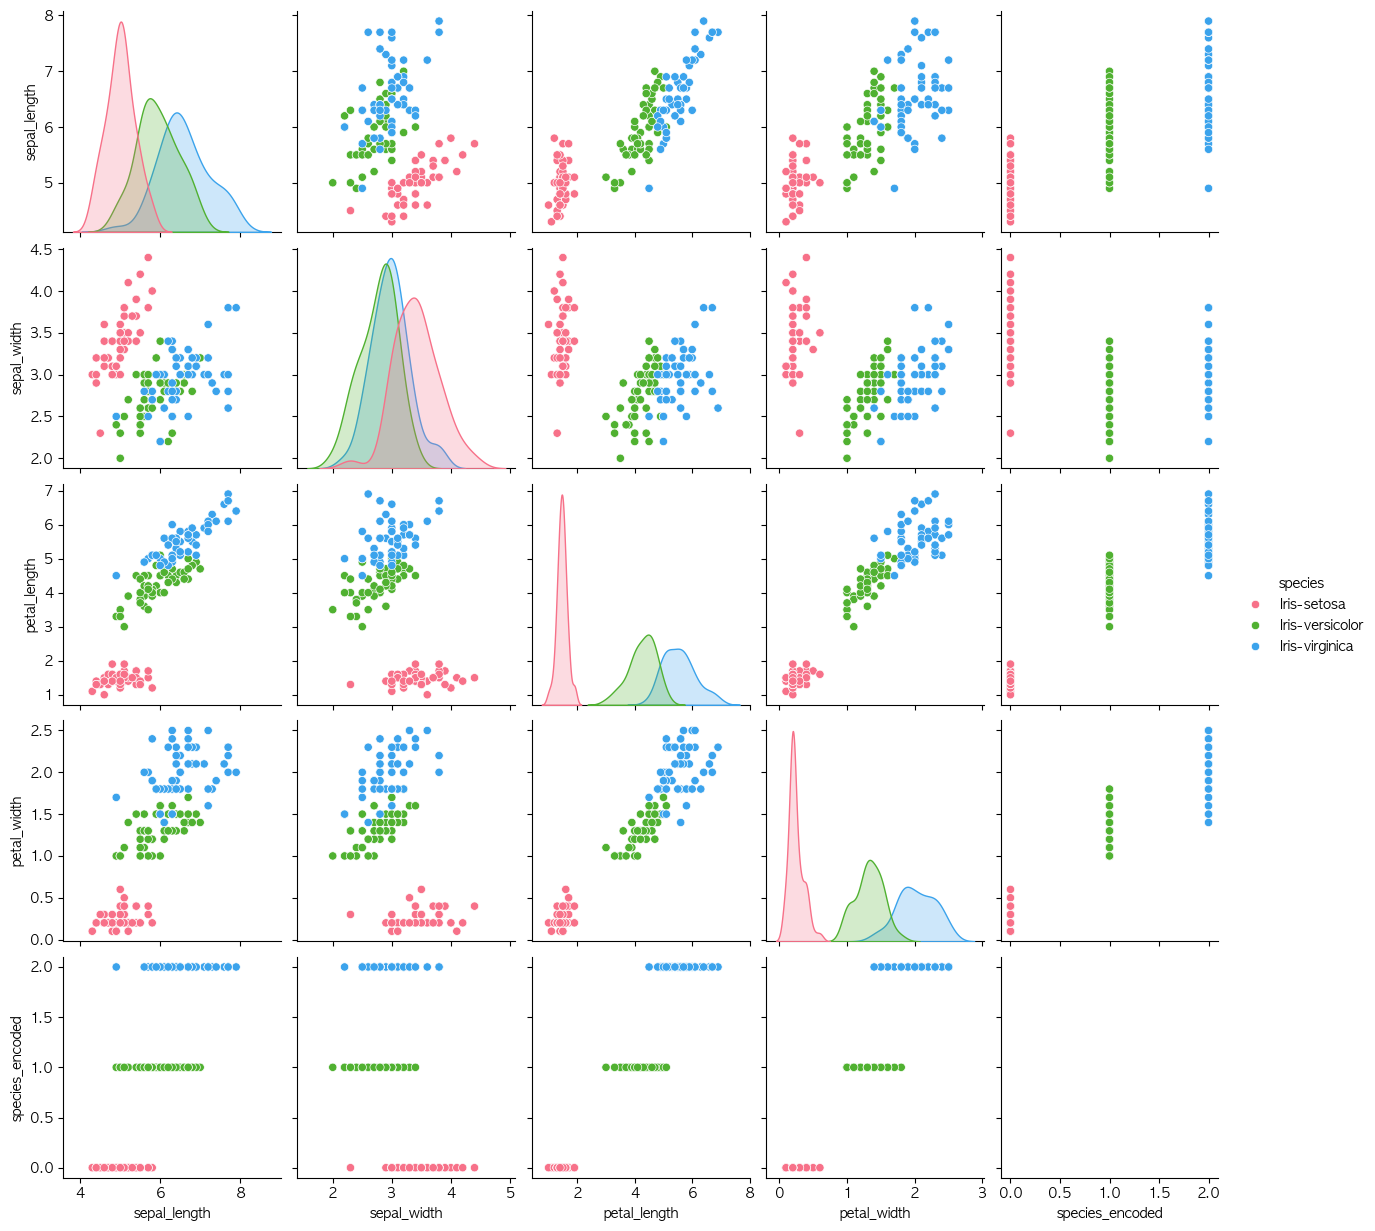

In [4]:
sns.pairplot(df, hue='species', palette='husl')
plt.show()

## 🛠 4. 데이터셋 분할 및 스케일링 (Split & Scale)

- **StandardScaler**: 딥러닝 학습 효율을 위해 데이터를 평균 0, 표준편차 1로 스케일링합니다.
- **Train/Test Split**: 학습용(80%)과 테스트용(20%)으로 데이터를 나눕니다.

In [5]:
# Feature & Target
X = df.drop(['species', 'species_encoded'], axis=1)
y = df['species_encoded']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (120, 4), Test: (30, 4)


## 🧠 5. 딥러닝 모델링 (Deep Learning)

### 5.1 MLP 아키텍처
- **Input**: 4 Features
- **Hidden**: 16 Units (`ReLU`)
- **Output**: 3 Units (`Softmax`)
    - **Softmax**: 3개 클래스에 대한 확률을 출력하며, 총합은 1이 됩니다.

**손실 함수(Loss Function)**
- `sparse_categorical_crossentropy`: 타겟이 정수(0, 1, 2)일 때 사용합니다. (One-hot encoding 불필요)

In [6]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(4,)),
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')  # 3개 클래스
])

model.compile(optimizer=Adam(learning_rate=0.01), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-07 16:55:53.694397: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2026-01-07 16:55:53.694430: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2026-01-07 16:55:53.694437: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 25.92 GB
2026-01-07 16:55:53.694455: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-07 16:55:53.694466: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fac

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243 (972.00 B)

 Trainable params: 243 (972.00 B)

 Non-trainable params: 0 (0.00 B)

2026-01-07 16:56:40.985011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


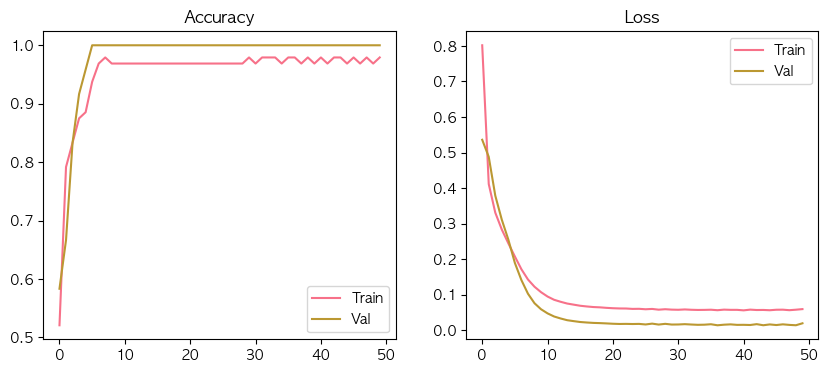

In [7]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_split=0.2,
    verbose=0
)

# 학습 결과 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

## ⚖️ 6. 성능 평가 (Evaluation)

### 6.1 최종 정확도 및 혼동 행렬

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Final Accuracy: 1.0000


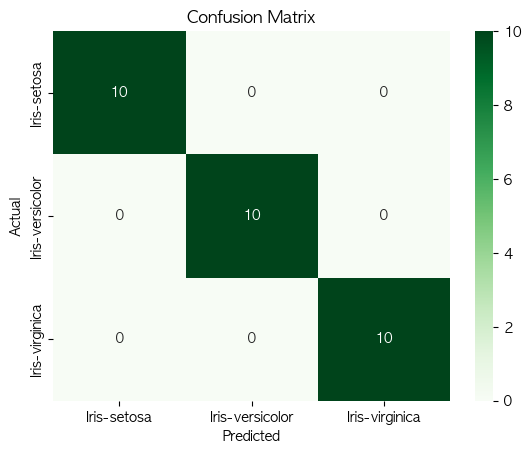

In [8]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # 확률이 가장 높은 인덱스 추출

acc = accuracy_score(y_test, y_pred)
print(f"Final Accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 💡 7. 결론 (Conclusion)
- 아마도 95~100%의 매우 높은 정확도를 달성했을 것입니다. Iris 데이터는 변수 분리가 잘 되어 있어 딥러닝으로 매우 쉽게 분류됩니다.
- 3개 이상의 클래스를 분류할 때는 **Softmax**와 **Sparse Categorical Crossentropy** 조합이 표준임을 기억하세요.